In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

c:\Users\yosef\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
def preprocess_manga_batch(raw_folder, sample_size, target_size=(256, 256)) :
    """
    Preprocess all manga images in a folder (e.g., RawImages/1.jpg to RawImages/204.jpg).
    Returns:
        - Grayscale images (input for the model).
        - Original colored images (target for training, if available).
    """
    grayscale_images = []
    colored_images = []

    # Loop through all images in the folder (1.jpg to 204.jpg)
    for i in range(1, sample_size + 1):  # Adjust range if needed
        img_path = os.path.join(raw_folder, f"{i}.jpg")
        
        # Check if the file exists
        if not os.path.exists(img_path):
            print(f"Warning: {img_path} not found. Skipping.")
            continue
        
        # Load the image (assuming it's colored; if grayscale, skip conversion)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Failed to load {img_path}. Skipping.")
            continue
        
        # Convert to RGB (OpenCV loads as BGR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize
        img_resized = cv2.resize(img_rgb, target_size)
        
        # Normalize to [0, 1]
        img_normalized = img_resized.astype('float32') / 255.0
        
        # Append to lists
        colored_images.append(img_normalized)  # Original colored image
        
        # Convert to grayscale (input for the model)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        img_gray = np.expand_dims(img_gray, axis=-1)  # Add channel dimension (256,256,1)
        grayscale_images.append(img_gray)
    
    # Convert lists to NumPy arrays
    grayscale_images = np.array(grayscale_images)
    colored_images = np.array(colored_images)
    
    return grayscale_images, colored_images

In [ ]:
# Usage
raw_folder = "RawImages"  # Folder containing 1.jpg to 204.jpg
test_folder = "TestImages"

x_train_gray, x_train_color = preprocess_manga_batch(raw_folder, 204)
x_test_gray, x_test_color = preprocess_manga_batch(test_folder, 18)


print(f"Grayscale images shape: {x_train_gray.shape}")  # (N, 256, 256, 1)
print(f"Colored images shape: {x_train_color.shape}")    # (N, 256, 256, 3)
print(f"Grayscale images shape: {x_test_gray.shape}")  # (N, 256, 256, 1)
print(f"Colored images shape: {x_test_color.shape}")    # (N, 256, 256, 3)


np.save("x_train_grayDS.npy", x_train_gray)
np.save("x_train_colorDS.npy", x_train_color)
np.save("x_test_grayDS.npy", x_test_gray)
np.save("x_test_colorDS.npy", x_test_color)

Grayscale images shape: (204, 256, 256, 1)
Colored images shape: (204, 256, 256, 3)
Grayscale images shape: (18, 256, 256, 1)
Colored images shape: (18, 256, 256, 3)


In [ ]:
x_train_gray = np.load("x_train_grayDS.npy")
x_train_color = np.load("x_train_colorDS.npy")
x_test_gray = np.load("x_test_grayDS.npy")
x_test_color = np.load("x_test_colorDS.npy")

In [ ]:
x_train_gray = np.load("x_train_grayOP.npy")
x_train_color = np.load("x_train_colorOP.npy")
x_test_gray = np.load("x_test_grayOP.npy")
x_test_color = np.load("x_test_colorOP.npy")

In [3]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Bottleneck
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    
    # Output layer (3 channels for RGB)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build the model
input_shape = (256, 256, 1)  # Grayscale manga image shape
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 740,227 (2.82 MB)

 Trainable params: 740,227 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    x_train_gray, x_train_color,  # Grayscale input, colored output
    epochs=50,
    batch_size=16
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.1429
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0849
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0671
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0574
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0464
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.0435
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0415
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0402
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 0.0383
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.0364
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.0361
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0345
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.0332
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0325
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0319
Epoch 16/50
18/18 ━

In [5]:
model.save("unet_colorizationOP.keras")

In [ ]:
model = load_model("unet_colorizationOP.keras")

c:\Users\yosef\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
def enhance_colors(image, saturation_factor=3.0, contrast=1.5, brightness=10):
    """
    Turbo-charge colors!
    Args:
        image: Predicted RGB image (0-1 or 0-255 range).
        saturation_factor: 3.0 = 3× more saturation.
        contrast: 1.5 = 50% more contrast.
        brightness: +10 = slight brightness boost.
    Returns:
        Vibrant RGB image.
    """
    # Convert to [0, 255] if needed
    if image.max() <= 1.0:
        image = (image * 255).astype('uint8')
    
    # Convert to HSV (for saturation control)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv = hsv.astype('float32')
    
    # Boost saturation (hard!)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation_factor, 0, 255)
    
    # Convert back to RGB
    saturated = cv2.cvtColor(hsv.astype('uint8'), cv2.COLOR_HSV2RGB)
    
    # Boost contrast and brightness
    final = cv2.convertScaleAbs(saturated, alpha=contrast, beta=brightness)
    
    return final

In [8]:
prediction = model.predict(x_test_gray)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


In [9]:
def display_results(grayscale, predicted, original, post_processed):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.title('Original')
    plt.imshow(original)

    plt.subplot(1, 4, 2)
    plt.title('Grayscale')
    plt.imshow(grayscale, cmap='gray')
    
    plt.subplot(1, 4, 3)
    plt.title('Predicted')
    plt.imshow(predicted)
    
    plt.subplot(1, 4, 4)
    plt.title('Post Processed')
    plt.imshow(post_processed)

    plt.show()

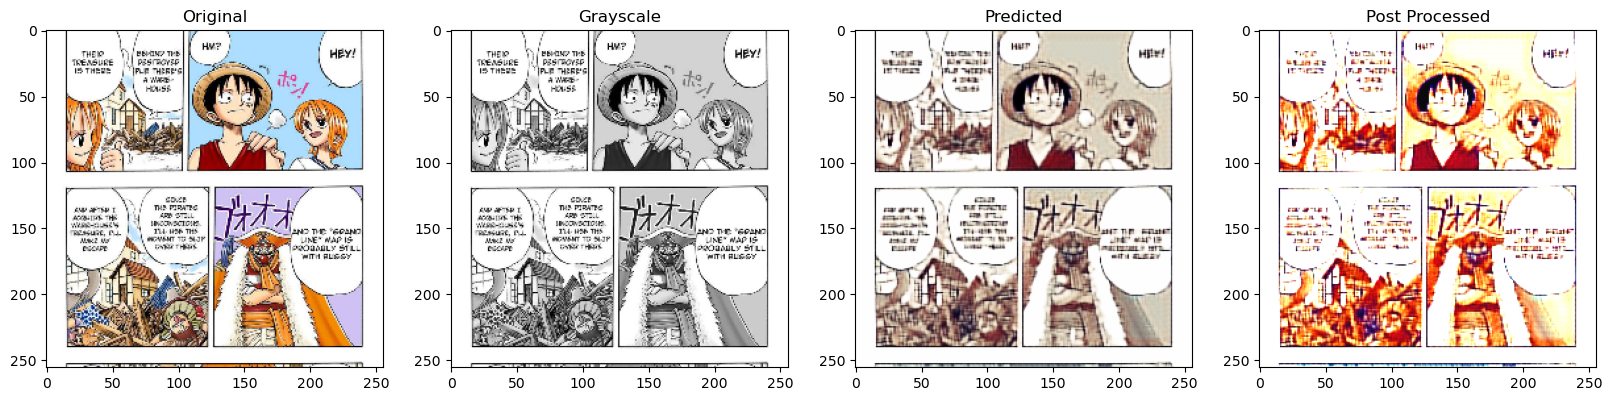

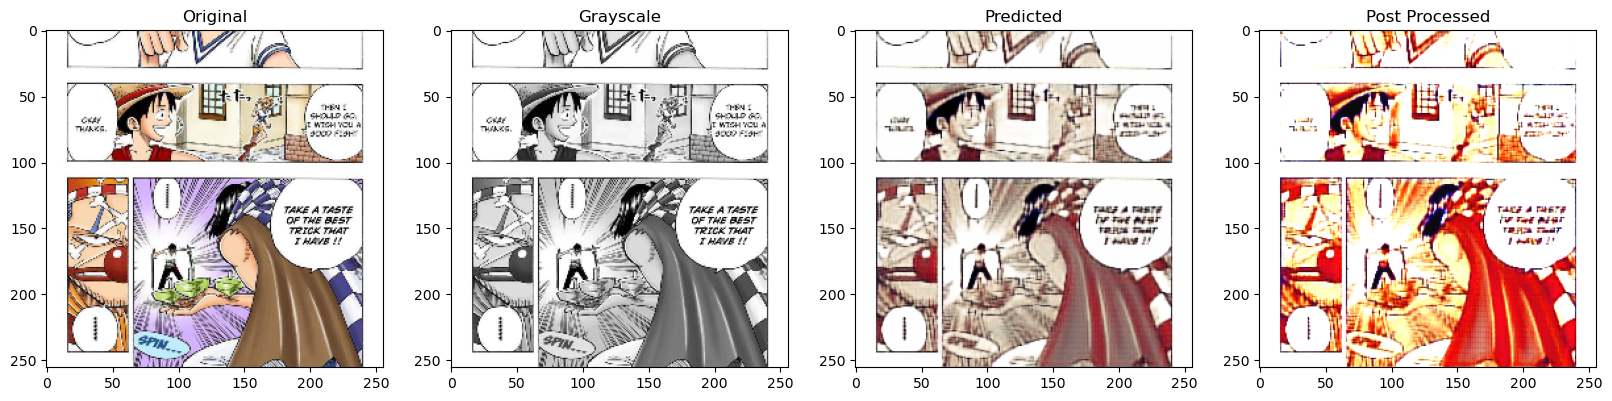

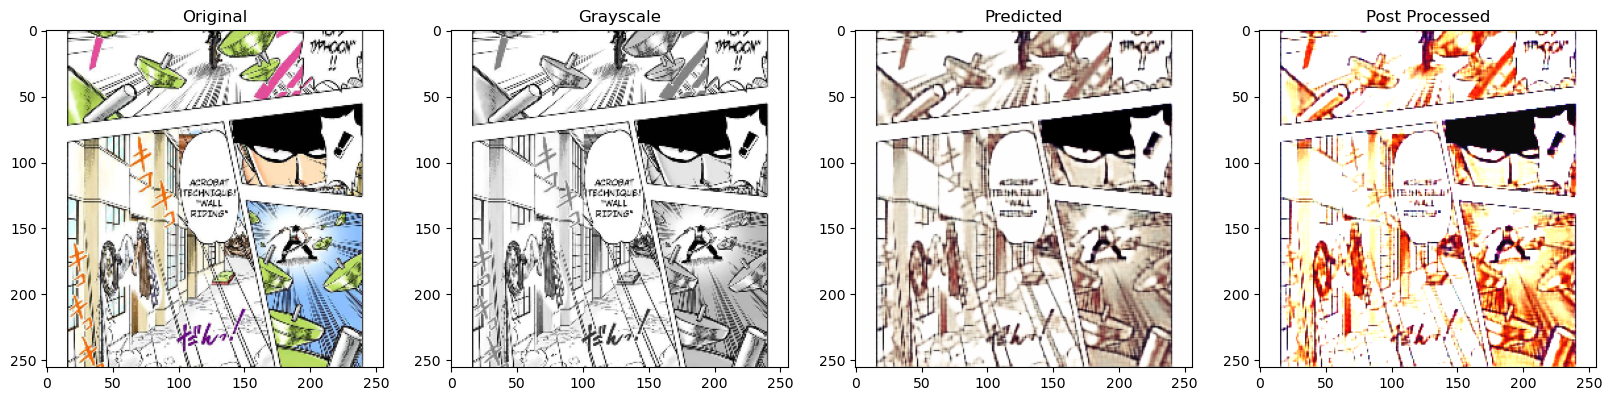

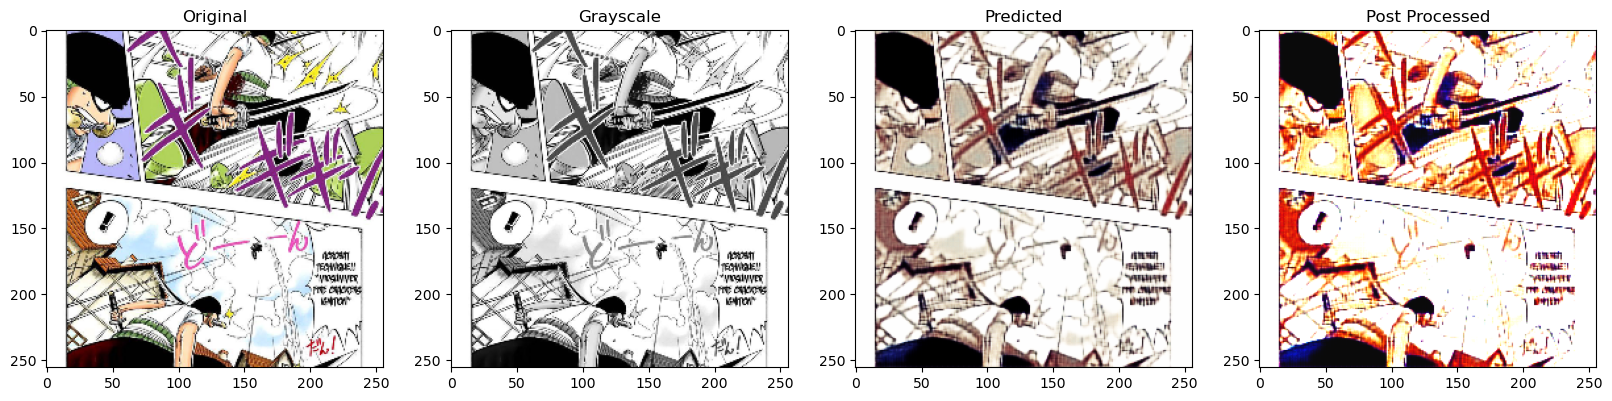

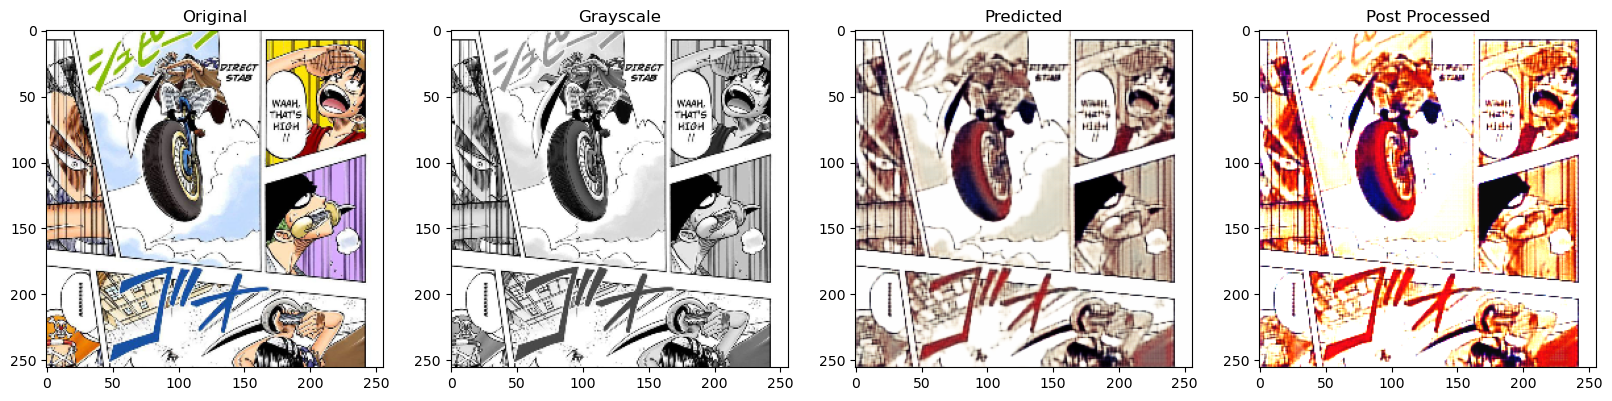

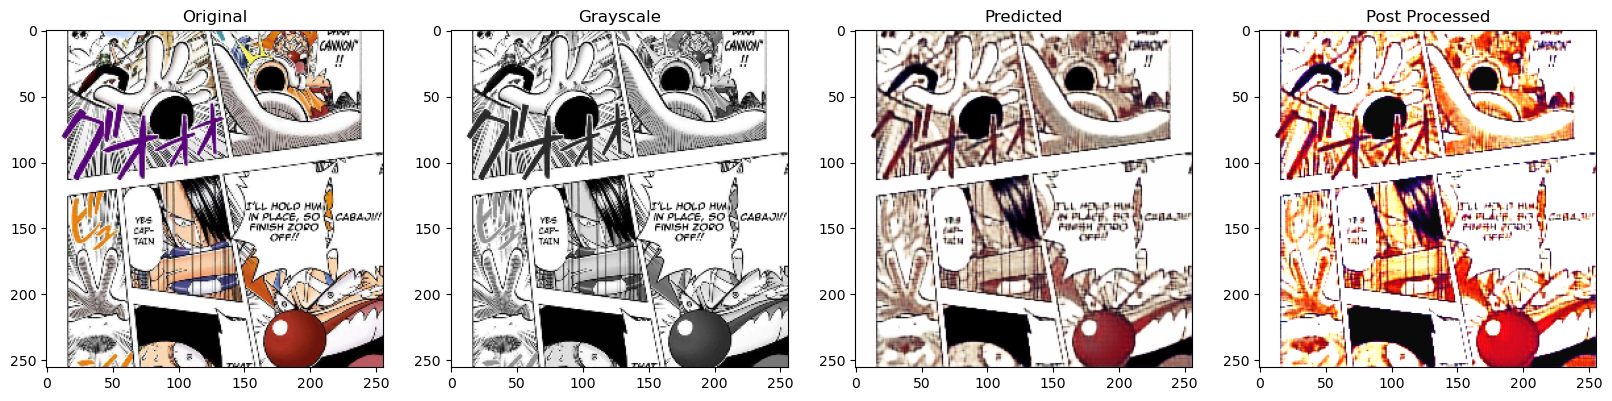

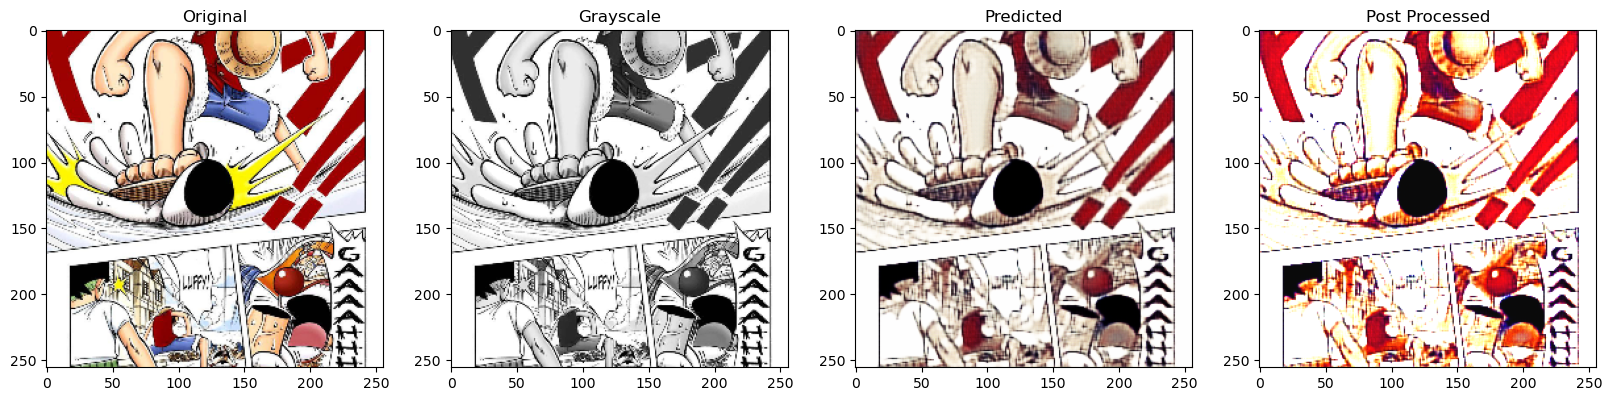

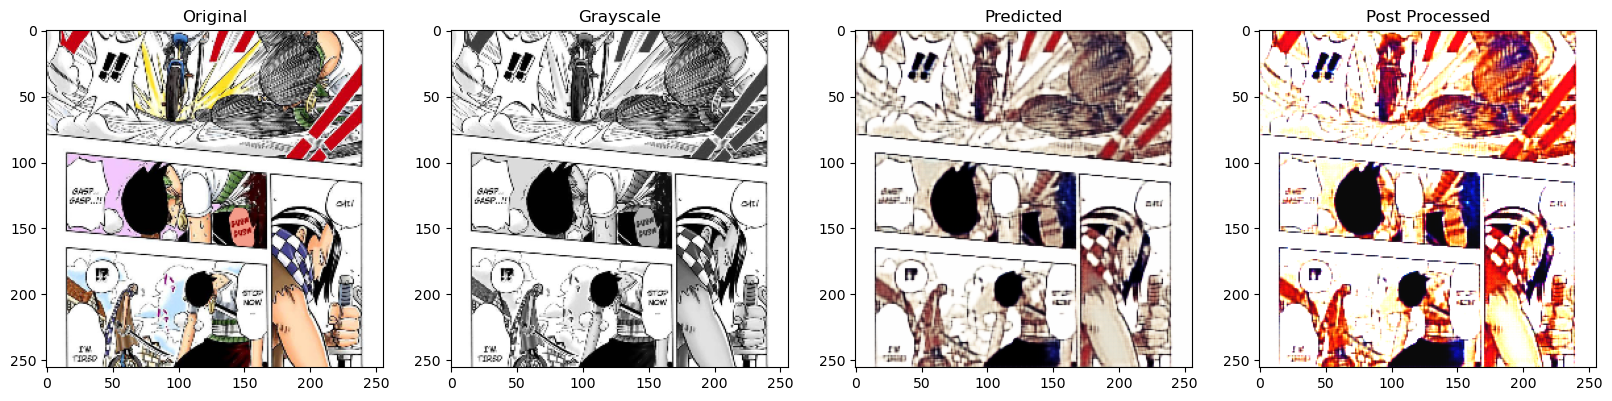

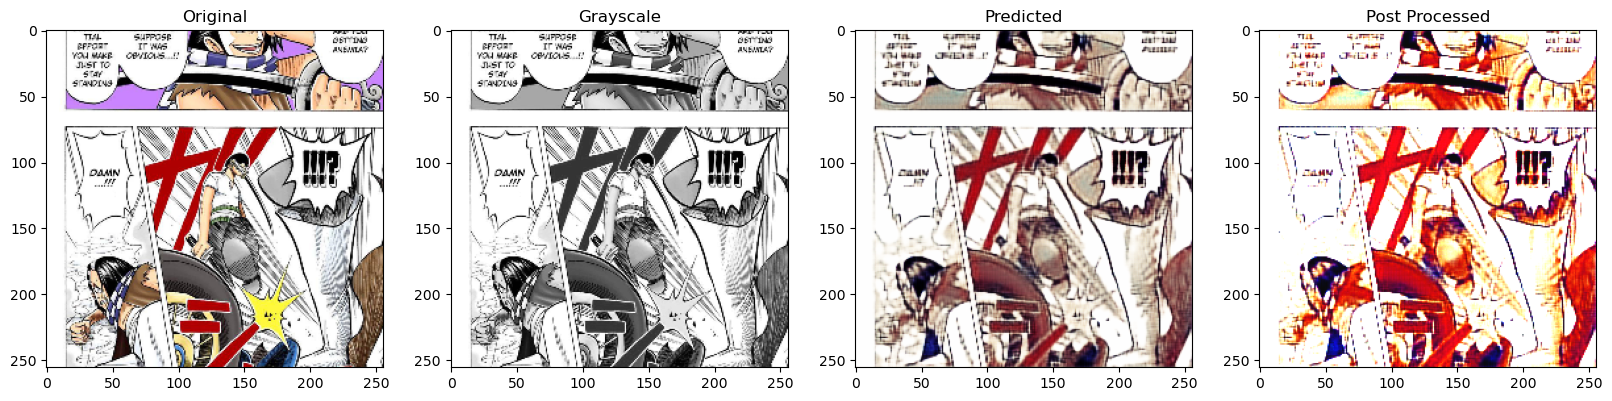

In [10]:
for i in range(10):
    post_processed = enhance_colors(prediction[i])
    display_results(x_test_gray[i], prediction[i], x_test_color[i], post_processed)